### Digit Recognition Project

In [20]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

### Data Loading and Exploration

In [21]:
labeled_images = np.load("data/labeled_images.npy")
labeled_digits = np.load("data/labeled_digits.npy")
autograder_images = np.load("data/autograder_images.npy")

In [22]:
# This is an array containing all the 3750 images of size 28 times 28 pixels:
labeled_images.shape

(3750, 28, 28)

Text(0, 0.5, 'Frequency')

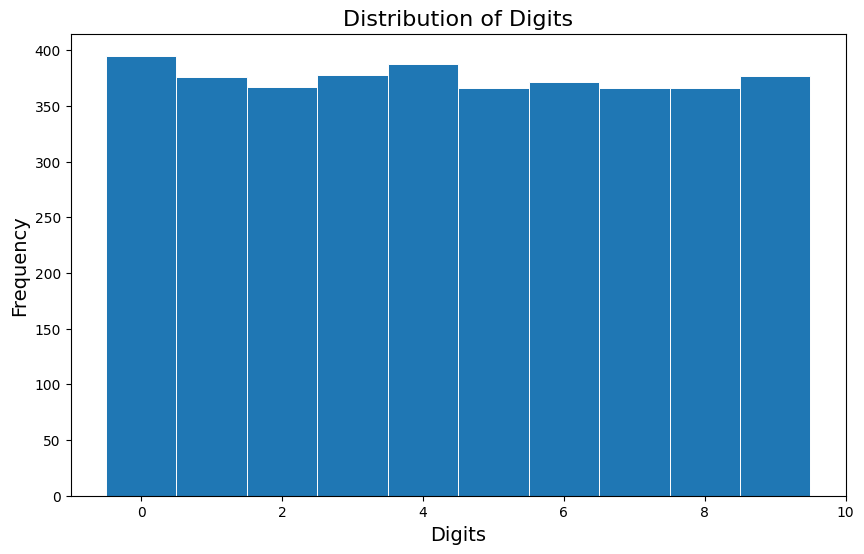

In [23]:
# Understanding the data distribution

digits, counts = np.unique(labeled_digits, return_counts=True)
fig, ax = plt.subplots(figsize=(10, 6)) 

ax.bar(digits, counts, width=1, edgecolor="white", linewidth=0.7)
ax.set_title('Distribution of Digits', fontsize=16)  
ax.set_xlabel('Digits', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14) 

# Observation: Equal distribution of classes (in this problem, our classes are digits). We have a balanced dataset.

In [24]:
# This is an array containing the digit corresponding to each image:
labeled_digits[0:100]

array([1, 7, 0, 5, 2, 8, 4, 0, 4, 2, 2, 3, 4, 7, 2, 8, 0, 9, 2, 5, 4, 1,
       1, 6, 3, 6, 4, 9, 9, 7, 2, 4, 5, 1, 5, 7, 0, 4, 4, 6, 3, 0, 6, 5,
       0, 9, 7, 8, 0, 6, 1, 8, 4, 8, 9, 1, 4, 8, 0, 0, 7, 9, 1, 8, 9, 3,
       4, 9, 0, 5, 9, 6, 4, 0, 9, 4, 0, 6, 3, 1, 8, 9, 0, 8, 0, 1, 6, 4,
       4, 6, 1, 2, 7, 2, 0, 0, 5, 9, 2, 7])

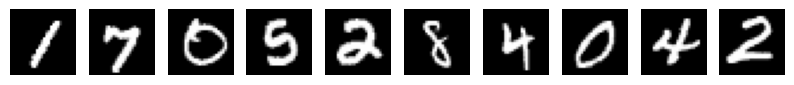

In [25]:
num_images = 10
plt.figure(figsize=(10, 2))

for i in range(num_images):
    image = labeled_images[i]
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()

# Observation: The dataset is already in grayscale. It does not have any color channels, it is 2-dimensional.

### Data Preprocessing

In [26]:
# Normalization

from PIL import Image
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()

    mean /= num_pixels
    std /= num_pixels

    return mean, std

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Step 1: Create a Tensor dataset out of the images
input = labeled_images
labels = labeled_digits

images = torch.stack([data_transforms(Image.fromarray(image)) for image in labeled_images])
labels = torch.tensor([label for label in labeled_digits])
dataset = TensorDataset(images, labels)

# Step 2: Calculate the mean and standard deviation of the dataset
batch_size = 32
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
mean, std = get_mean_std(loader)

print(f"Before Normalization - Mean: {mean}, Std: {std}")

# Step 3: Normalize the dataset
normalized_data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

images = torch.stack([normalized_data_transforms(Image.fromarray(image)) for image in labeled_images])
dataset = TensorDataset(images, labels)

# Verify normalization
batch_size = 32
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
normal_mean, normal_std = get_mean_std(loader)

print(f"After Normalization - Mean: {normal_mean}, Std: {normal_std}")


Before Normalization - Mean: 8.274315632661455e-08, Std: 1.82024166406336e-07
After Normalization - Mean: 0.4542149603366852, Std: 0.9995567798614502


### Baseline Model: Majority Class Classifier

As a reference point for our upcoming models, we chose to implement a Majority Class Classifier that predicts the most frequent class in the training set.

In [ ]:
digits, counts = np.unique(labeled_digits, return_counts=True)
most_frequent_digit = digits[np.argmax(counts)]

print(f"The most frequent digit is: {most_frequent_digit}")
print(f"All images will be classified as {most_frequent_digit}...")

accuracy = counts[most_frequent_digit] / labeled_digits.shape[0]
print(f"Accuracy of the Majority Class Classifier: {accuracy}")

The most frequent digit is: 0
All images will be classified as 0...
Accuracy of the Majority Class Classifier: 0.10533333333333333


### Prepare autograder submission

In the autograder you will need to provide two things: 1) estimate of the accuracy of your model on unseen data, 2) the predictions on the autograder images. For the autograder images we only provide the images and not the class labels. Thus, you cannot compute the accuracy on this data yourself - you need to estimate that with labeled data that is provided (labeled_images, labeled_digits). We will calculate the accuracy for you on the autograder data and you will receive an automatic grade based on this. 

In [28]:

estimate = np.array([0.7]) # TODO Replace this with your estimate of the accuracy on new data
prediction = np.array([-1] * len(autograder_images)) # TODO Replace this with your predictions of your best model
# For example using something like:
# prediction = my_super_duper_model.predict(autograder_images) 

result = np.append(estimate, prediction)

# The code below will write your estimate and prediction to a file named autograder.txt
# You will need to upload this file to the Vocareum autograder
pd.DataFrame(result).to_csv("autograder.txt", index=False, header=False)